In [1]:
# Query time for object display page
from io import StringIO
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import brokenaxes

BOX_WIDTH = 3.5
BOX_HEIGHT = 8
DATA_WIDTH = 0.6

# Helper functions
# Strips URLs to get an ID
def strip_urls(base, url):
    return int(url.replace(base, ""))
LINKS_URL = "/objectDisplay?objectId="
JAVA_URL = "http://localhost:9080/GRAC/ObjectDisplayForward?objectId=" # TODO

In [2]:
# First, read in the CSV files. We need to add in the header.
links_querytime_contents = ""
java_querytime_contents = ""
with open("../results/links_objectdisplay_querytime.csv", 'r') as f:
    links_querytime_contents = "id,query_count,execution_time,total_time\n" + f.read()
with open("../results/java_objectdisplay_querytime.csv", 'r') as f:
    java_querytime_contents = "id,query_count,execution_time\n" + f.read()

In [3]:
# Read the frame
links_frame = pandas.read_csv(StringIO(links_querytime_contents))

In [4]:
# Do some transformations
links_frame['id'] = links_frame['id'].apply(lambda x: strip_urls(LINKS_URL, x))
links_frame = links_frame.groupby(['id'], as_index = False).mean()

In [5]:
# Now, let's do the same stuff for the Java data
java_frame = pandas.read_csv(StringIO(java_querytime_contents))
java_frame['id'] = java_frame['id'].apply(lambda x: strip_urls(JAVA_URL, x))
java_frame = java_frame.groupby(['id'], as_index = False).mean()
java_time_frame = java_frame.drop(['query_count'], axis=1)

In [6]:
# Now get some summary statistics
lqc = links_frame['query_count']
jqc = java_frame['query_count']

print("Mean query count for Links: " + str(lqc.mean()))
print("Median query count for Links: " + str(lqc.median()))

print("Mean query count for Java: " + str(jqc.mean()))
print("Median query count for Java: " + str(jqc.median()))

print("QC Standard Deviation for Links: " + str(lqc.std()))
print("QC Standard Deviation for Java: " + str(jqc.std()))

print(" ")
# Now get some summary statistics
lqt = links_frame['total_time']
jqt = java_frame['execution_time']

print("Mean execution time for Links: " + str(lqt.mean()))
print("Median query time for Links: " + str(lqt.median()))

print("Mean query time for Java: " + str(jqt.mean()))
print("Median query time for Java: " + str(jqt.median()))

print("QT Standard Deviation for Links: " + str(lqt.std()))
print("QT Standard Deviation for Java: " + str(jqt.std()))

Mean query count for Links: 120.83333333333333
Median query count for Links: 108.0
Mean query count for Java: 307.7866666666667
Median query count for Java: 229.0
QC Standard Deviation for Links: 43.3845635905426
QC Standard Deviation for Java: 275.1491258059297
 
Mean execution time for Links: 105.4124218648889
Median query time for Links: 101.35986813333335
Mean query time for Java: 175.35436593022223
Median query time for Java: 57.76646836666667
QT Standard Deviation for Links: 12.291988584614304
QT Standard Deviation for Java: 204.3972605297296


In [7]:
# Now, to do calculations on the query time, we drop the query count
links_time_frame = links_frame.drop(['query_count'], axis=1)
# We add a new column for normalisation time by subtracting execution time from total time
normalisation_time = links_time_frame.apply(lambda x: x['total_time'] - x['execution_time'], axis=1)
links_time_frame.insert(1, 'normalisation_time', normalisation_time)
links_time_frame = links_time_frame.drop(['total_time'], axis=1)
links_time_frame = links_time_frame.set_index('id')

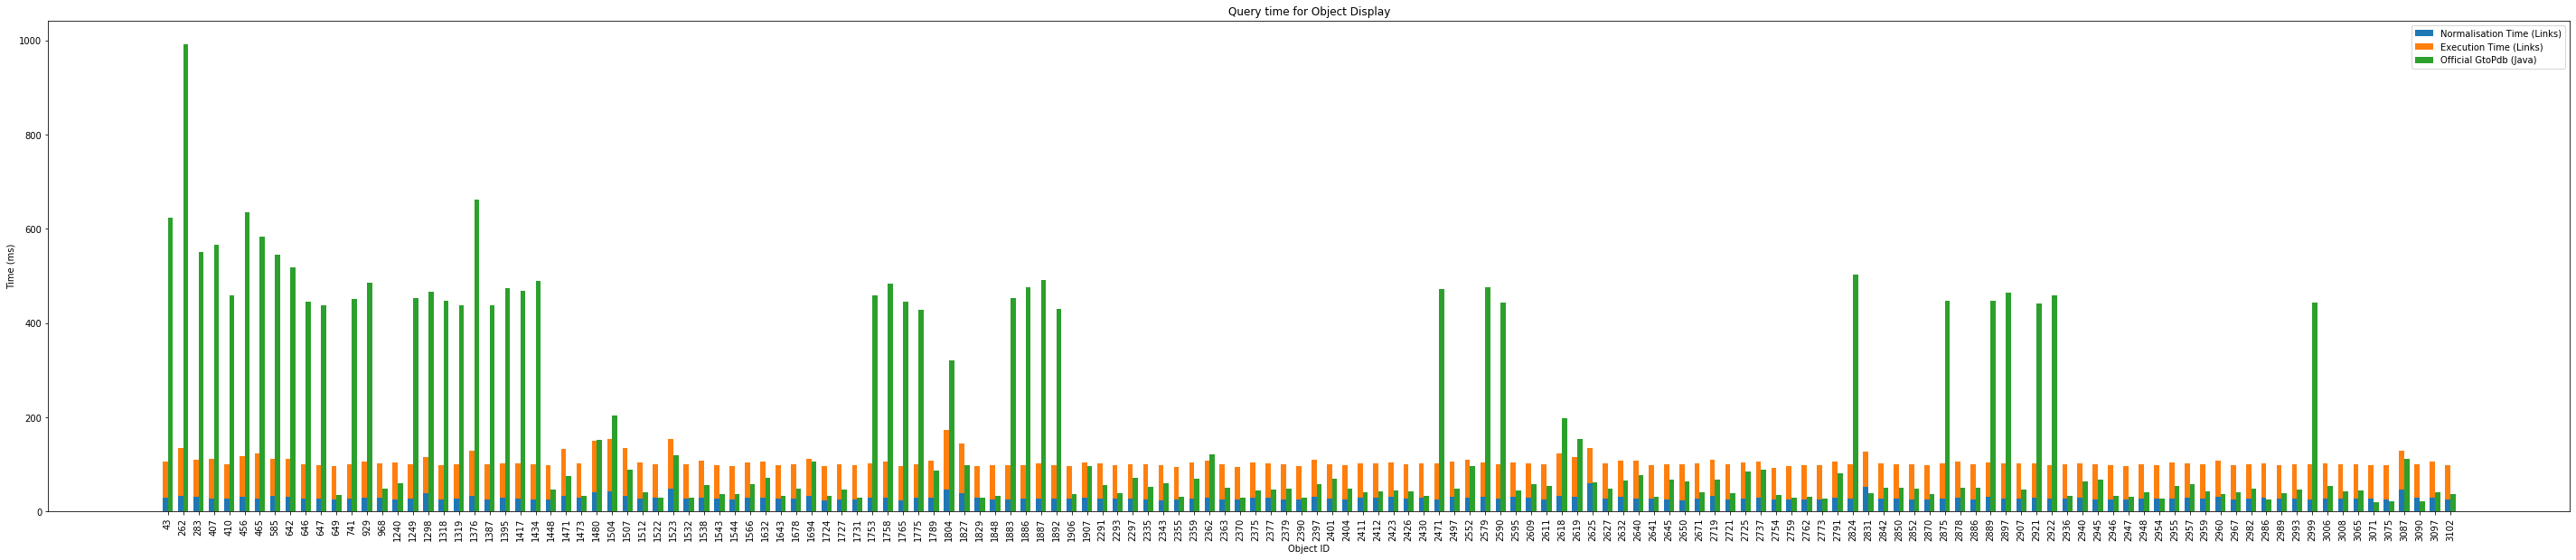

In [8]:
width = 0.05
scale_factor = 0.15
ind = np.arange(len(links_time_frame))
ind = [scale_factor * x for x in ind]
links_ind = [x - (width / 2) for x in ind]
java_ind = [x + (width / 2) for x in ind]
norm_time = links_time_frame['normalisation_time']
exec_time = links_time_frame['execution_time']
java_time = java_time_frame['execution_time']

plt.figure(figsize=(50,10))

p1 = plt.bar(links_ind, exec_time, width=width)
p2 = plt.bar(links_ind, exec_time, width=width, bottom=norm_time)
p3 = plt.bar(java_ind, java_time, width=width)

plt.ylabel('Time (ms)')
plt.xlabel('Object ID')
plt.xticks(ind, links_time_frame.index, rotation='vertical')

plt.title('Query time for Object Display')
plt.legend((p1[0], p2[0], p3[0]), ('Normalisation Time (Links)', 'Execution Time (Links)', 'Official GtoPdb (Java)'))

plt.savefig("objectdisplay_querytime_bar.pdf", bbox_inches='tight')


In [9]:
links_count_frame = links_frame.drop(['execution_time', 'total_time'], axis=1)
java_count_frame = java_frame.drop(['execution_time'], axis=1)

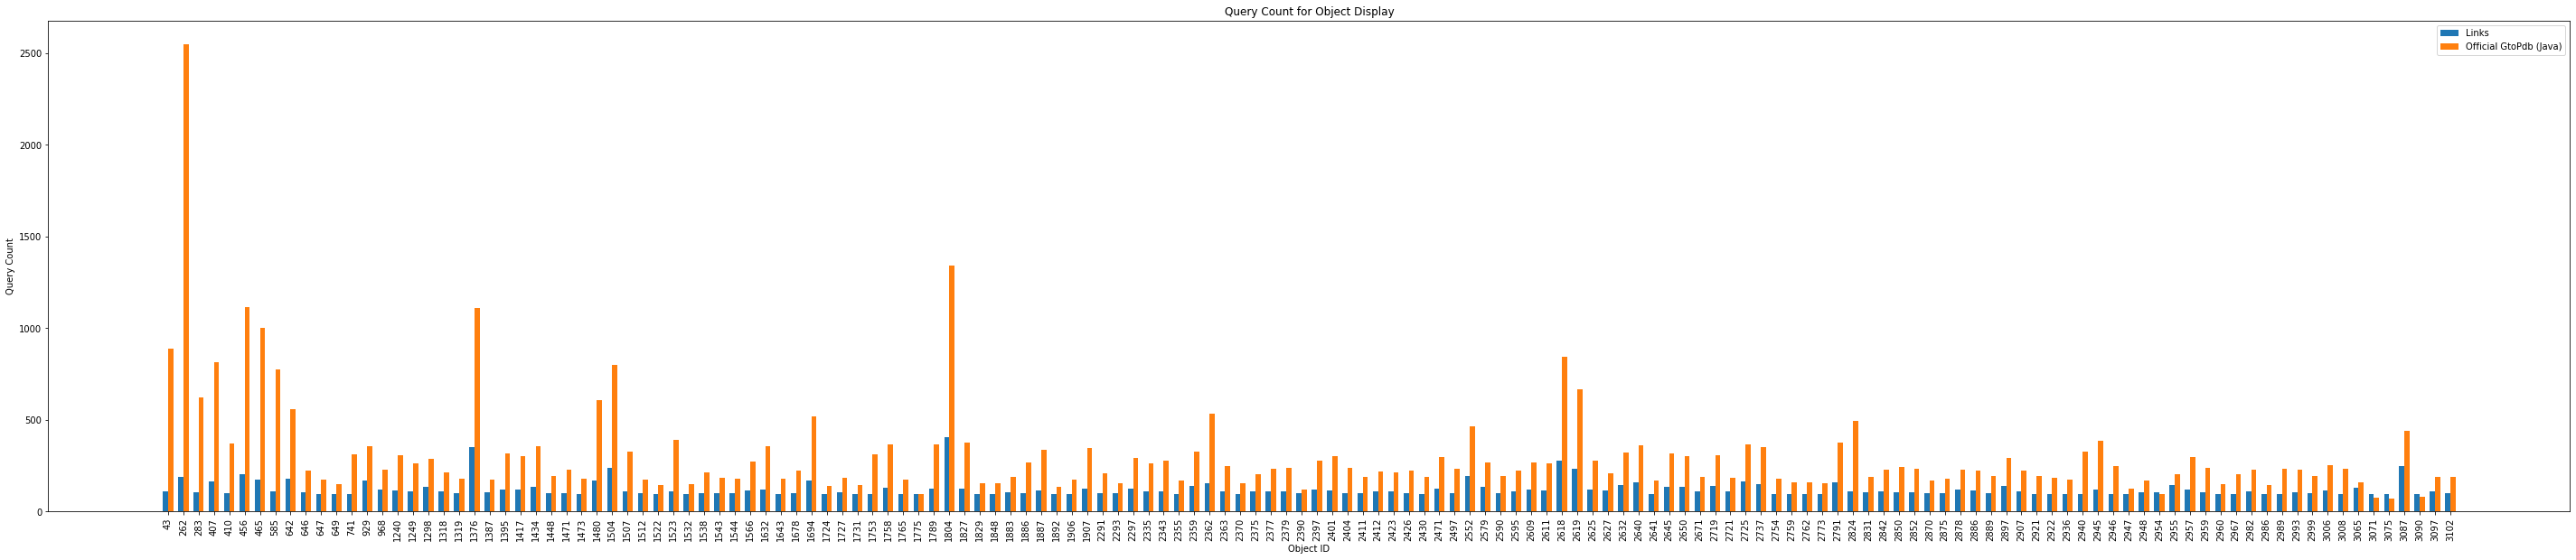

In [10]:
links_qc = links_frame['query_count']
java_qc = java_frame['query_count']

plt.figure(figsize=(50,10))

p1 = plt.bar(links_ind, links_qc, width=width)
p2 = plt.bar(java_ind, java_qc, width=width)

plt.ylabel('Query Count')
plt.xlabel('Object ID')
plt.xticks(ind, links_time_frame.index, rotation='vertical')

plt.title('Query Count for Object Display')
plt.legend((p1[0], p2[0]), ('Links', 'Official GtoPdb (Java)'))

plt.savefig("objectdisplay_querycount_bar.pdf", bbox_inches='tight')

In [11]:
# Now, let's do some box plots. For this, it's useful to join the two frames together.
joined_time_frame = pandas.merge(left=links_time_frame,right=java_time_frame, left_on='id', right_on='id')
joined_time_frame =\
    joined_time_frame.rename(columns={"execution_time_x": "Links",\
                                      "execution_time_y": "Java"})
joined_time_frame = joined_time_frame.drop(['normalisation_time'], axis=1)
###
joined_count_frame = pandas.merge(left=links_count_frame,right=java_count_frame, left_on='id', right_on='id')
joined_count_frame =\
    joined_count_frame.rename(columns={"query_count_x": "Links",\
                                      "query_count_y": "Java"})

In [12]:
joined_count_frame

,id,Links,Java
0,43,109,890
1,262,190,2549
2,283,105,622
3,407,162,814
4,410,102,369
...,...,...,...
145,3075,96,72
146,3087,248,441
147,3090,96,80
148,3097,108,187


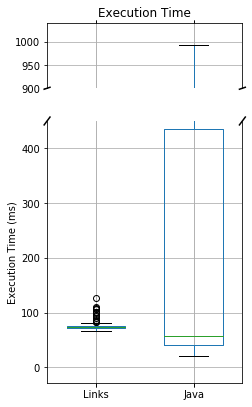

In [13]:
jtf = joined_time_frame[['Links', 'Java']]

fig, (ax1, ax2) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [0.5, 2]}, sharex=True)
jtf.boxplot(ax=ax1, widths=DATA_WIDTH)
ax1.set_xlabel('')
ax1.set_ylim(ymin=900)

jtf.boxplot(ax=ax2, widths=DATA_WIDTH)
ax2.set_title('')
ax2.set_ylim(ymax=450)
fig.set_size_inches(BOX_WIDTH, BOX_HEIGHT)
fig.subplots_adjust(top=0.75)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
d4 = d * 4
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Execution Time (ms)')
ax1.title.set_text("Execution Time")
fig.savefig("objectdisplay_querytime_box.pdf", bbox_inches='tight')

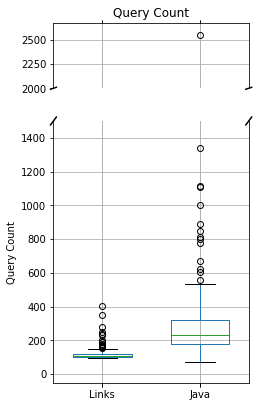

In [14]:
jtf = joined_count_frame[['Links', 'Java']]

fig, (ax1, ax2) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [0.5, 2]}, sharex=True)
jtf.boxplot(ax=ax1, widths=DATA_WIDTH)
ax1.set_xlabel('')
ax1.set_ylim(ymin=2000)

jtf.boxplot(ax=ax2, widths=DATA_WIDTH)
ax2.set_title('')
ax2.set_ylim(ymax=1500)
fig.set_size_inches(BOX_WIDTH, BOX_HEIGHT)
fig.subplots_adjust(top=0.75)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
d4 = d * 4
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Query Count')
ax1.title.set_text("Query Count")
fig.savefig("objectdisplay_querycount_box.pdf", bbox_inches='tight')

In [15]:
joined_time_frame

,id,Links,Java
0,43,77.739271,624.240255
1,262,101.381826,993.021034
2,283,79.109844,550.327173
3,407,83.288002,565.942323
4,410,73.042933,458.442887
...,...,...,...
145,3075,71.409130,21.671490
146,3087,83.143377,112.358276
147,3090,70.572901,21.245772
148,3097,76.384799,40.993763


In [16]:
# OK, now let's do it for page build time too
links_pagebuild_contents = ""
java_pagebuild_contents = ""
with open("../results/links_objectdisplay_pagetime.csv", 'r') as f:
    links_pagebuild_contents = "id,time\n" + f.read()
with open("../results/java_objectdisplay_pagetime.csv", 'r') as f:
    java_pagebuild_contents = "id,time\n" + f.read()
    
links_frame = pandas.read_csv(StringIO(links_pagebuild_contents))
links_frame['id'] = links_frame['id'].apply(lambda x: strip_urls(LINKS_URL, x))
links_frame = links_frame.groupby(['id'], as_index = False).mean()

java_frame = pandas.read_csv(StringIO(java_pagebuild_contents))
java_frame['id'] = java_frame['id'].apply(lambda x: strip_urls(JAVA_URL, x))
java_frame = java_frame.groupby(['id'], as_index = False).mean()

In [17]:
# Merge the frames on ID column, rename, box plot
joined_page_frame = pandas.merge(left=links_frame,right=java_frame, left_on='id', right_on='id')
joined_page_frame =\
    joined_page_frame.rename(columns={"time_x": "links_pb",\
                                      "time_y": "java_pb"})

# Now, join with the time frame in order to subtract the query time
joined = pandas.merge(left=joined_time_frame, right=joined_page_frame, left_on='id', right_on='id')

links_time = joined.apply(lambda x: x['links_pb'] - x['Links'], axis=1)
java_time = joined.apply(lambda x: x['java_pb'] - x['Java'], axis=1)

joined = joined.drop(['Links', 'Java', 'links_pb', 'java_pb'], axis=1)

joined.insert(1, 'Links', links_time)
joined.insert(1, 'Java', java_time)

joined = joined.set_index('id')
joined

,Java,Links
id,,
43,33.471568,1158.156602
262,48.050855,1894.172335
283,27.445890,889.156818
407,33.006470,792.355061
410,23.962647,307.441139
...,...,...
3075,24.221418,319.078668
3087,26.464404,346.369600
3090,23.472779,353.402551


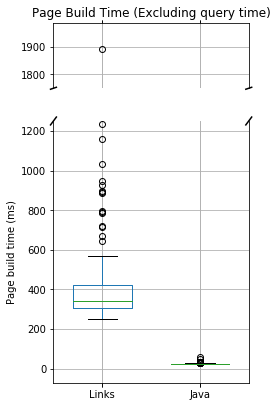

In [18]:
# Boxplot nonsense again
jtf = joined[['Links', 'Java']]
fig, (ax1, ax2) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [0.5, 2]}, sharex=True)
jtf.boxplot(ax=ax1, widths=DATA_WIDTH)
ax1.set_xlabel('')
ax1.set_ylim(ymin=1750)

jtf.boxplot(ax=ax2, widths=DATA_WIDTH)
ax2.set_title('')
ax2.set_ylim(ymax=1250)
fig.set_size_inches(BOX_WIDTH, BOX_HEIGHT)
fig.subplots_adjust(top=0.75)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
d4 = d * 4
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Page build time (ms)')
ax1.title.set_text("Page Build Time (Excluding query time)")
fig.savefig("objectdisplay_pagebuild_excl_box.pdf", bbox_inches='tight')

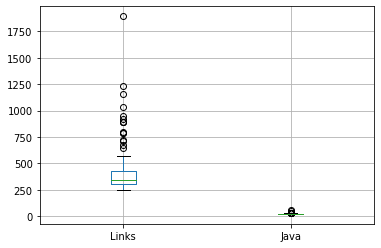

In [19]:
jtf.boxplot()

In [20]:
# Summary statistics
lpb = jtf['Links']
jpb = jtf['Java']

print("Median PB for Links: " + str(lpb.median()))
print("Median PB for Java: " + str(jpb.median()))

print("PB Standard Deviation for Links: " + str(lpb.std()))
print("PB Standard Deviation for Java: " + str(jpb.std()))

Median PB for Links: 340.12068916666664
Median PB for Java: 23.984837033333356
PB Standard Deviation for Links: 215.80674885332758
PB Standard Deviation for Java: 4.341316094283055


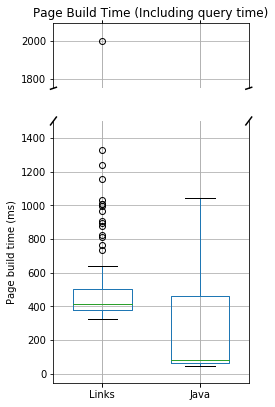

In [21]:
jtf =\
    joined_page_frame[['links_pb', 'java_pb']]\
        .rename(columns={"links_pb": "Links", "java_pb": "Java"})

# Boxplot nonsense again
fig, (ax1, ax2) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [0.5, 2]}, sharex=True)
jtf.boxplot(ax=ax1, widths=DATA_WIDTH)
ax1.set_xlabel('')
ax1.set_ylim(ymin=1750)

jtf.boxplot(ax=ax2, widths=DATA_WIDTH)
ax2.set_title('')
ax2.set_ylim(ymax=1500)
fig.set_size_inches(BOX_WIDTH, BOX_HEIGHT)
fig.subplots_adjust(top=0.75)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
d4 = d * 4
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Page build time (ms)')
ax1.title.set_text("Page Build Time (Including query time)")
fig.savefig("objectdisplay_pagebuild_incl_box.pdf", bbox_inches='tight')